In [ ]:
from google.colab import drive
drive.mount('/content/drive')  #access the images I have stored in my drive

Mounted at /content/drive


# First attempt

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, directories, transform=None):
        self.transform = transform
        self.samples = []

        for label, directory in enumerate(directories):
            for filename in os.listdir(directory):
                path = os.path.join(directory, filename)
                self.samples.append((path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, label

directories = ["/content/drive/My Drive/real_hands",
               "/content/drive/My Drive/VAE_hands",
               "/content/drive/My Drive/GAN_hands"]

train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(5),
    #transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = CustomDataset(directories)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.residual1 = self._make_residual(64, 128)
        self.residual2 = self._make_residual(128, 128)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 3)

    def _make_residual(self, in_channels, out_channels):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.residual1(x)
        x = self.residual2(x)
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EnhancedCNN().to(device)

EnhancedCNN is an advanced convolutional neural network model that incorporates BatchNorm layers and residual blocks to improve learning. It starts with two convolutional layers followed by batch normalisation and ReLU activation. Next, it implements two residual blocks that allow information to flow more efficiently through the network and avoid the problems of vanishing or exploding gradients, making the model deeper while facilitating training. The network ends with two fully connected layers with batch normalisation on the first. The model is adapted for classification into three classes

In [ ]:
weights = torch.tensor([1.0, 1.5, 2.0]) #weight to be given to each categoruie

weights = weights / weights.min()

criterion = nn.CrossEntropyLoss(weight=weights.to(device))

#print(weights)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
for epoch in range(50):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1} loss: {running_loss/len(train_loader)}')


Epoch 1 loss: 0.2067961845093885
Epoch 2 loss: 0.025016032982101612
Epoch 3 loss: 0.034389147247861115
Epoch 4 loss: 0.008083698423925435
Epoch 5 loss: 0.0019854961457305173
Epoch 6 loss: 0.0015846955782615475
Epoch 7 loss: 0.0001951212089880829
Epoch 8 loss: 8.959072931395133e-05
Epoch 9 loss: 6.736328759870958e-05
Epoch 10 loss: 5.5704711949270074e-05
Epoch 11 loss: 4.9388417769355204e-05
Epoch 12 loss: 4.381478544707312e-05
Epoch 13 loss: 3.7711453725588966e-05
Epoch 14 loss: 3.4253019650252e-05
Epoch 15 loss: 3.122031963308424e-05
Epoch 16 loss: 2.9191781359750656e-05
Epoch 17 loss: 2.5692372845868875e-05
Epoch 18 loss: 2.4418053579063633e-05
Epoch 19 loss: 2.2205469245032088e-05
Epoch 20 loss: 2.05702498152351e-05
Epoch 21 loss: 1.9068600545631705e-05
Epoch 22 loss: 1.753509244785213e-05
Epoch 23 loss: 1.6617791663668106e-05
Epoch 24 loss: 1.5733856042896986e-05
Epoch 25 loss: 1.4980769575428181e-05
Epoch 26 loss: 1.3799073946535606e-05
Epoch 27 loss: 1.3138512535128078e-05
Epoch 

In [ ]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
accuracy

81.78694158075601

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)


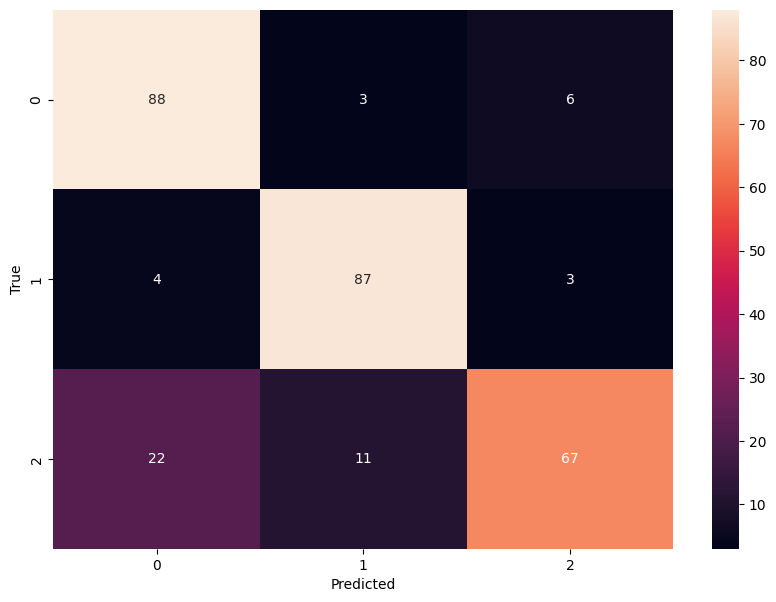

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Despite our attempts at optimisation, we're not getting satisfactory results. The shortcomings come mainly from the detection of our gan. Even if we exploit the asymmetry between real and gan detection by adding real images to our dataset, we obtain similar results.

------------------------------------------------------------

Given that the image classification for vae and real is very good with this model. I first tried to classify only vae and real and if the confidence in the prediction is higher than a thresold then the prediction is not modified and if it is lower then it is changed in 2 (for gan).

In [ ]:
def classify_vae_real_then_gan(image, model, threshold=0.9):
    output = model(image)
    confidence = torch.nn.functional.softmax(output, dim=1)
    _, predicted = torch.max(output.data, 1)

    if confidence[0][predicted] >= threshold:
        return predicted.item()
    else:
        return 2

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        for i in range(inputs.size(0)):
            pred = classify_vae_real_then_gan(inputs[i].unsqueeze(0), model)
            all_preds.append(pred)
            all_labels.append(labels[i].item())

correct = sum([1 for i in range(len(all_labels)) if all_labels[i] == all_preds[i]])
accuracy = 100 * correct / len(all_labels)
print(f'Combined Model Accuracy: {accuracy}%')


Combined Model Accuracy: 34.18803418803419%


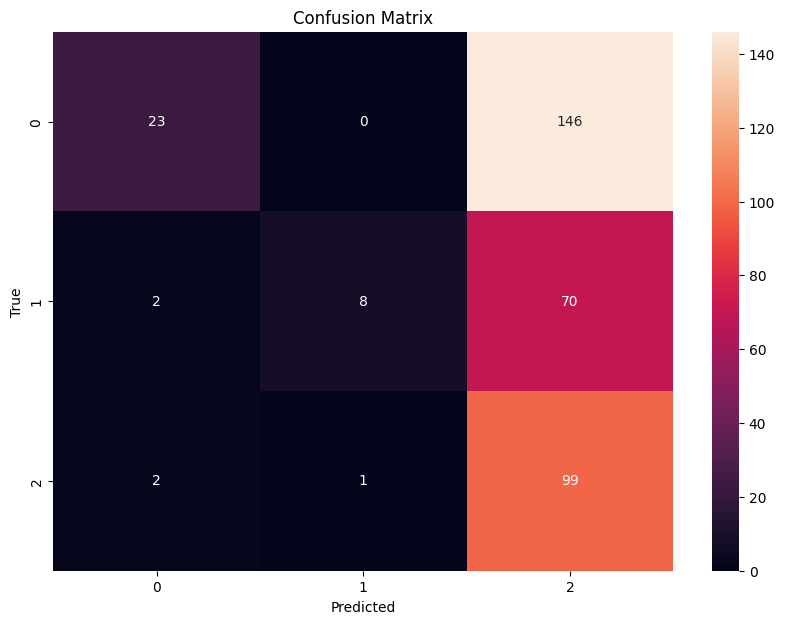

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        for i in range(inputs.size(0)):
            pred = classify_vae_real_then_gan(inputs[i].unsqueeze(0), model)
            all_preds.append(pred)
            all_labels.append(labels[i].item())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# It's very difficult to adjust the threshold, so I've given up on the track.

---------------------------------------------------------------------------

Last week I had a Gan and a VAE for assessment. I reused them here to generate 1000 images of each. I also used the previous data set real_hands to get 1000 images too. I trained my model on this alone and then ran the tests on the new data sets from assessment 2. The results weren't any better because my model had learned to detect only images from my generator, which isn't good. So I also gave up

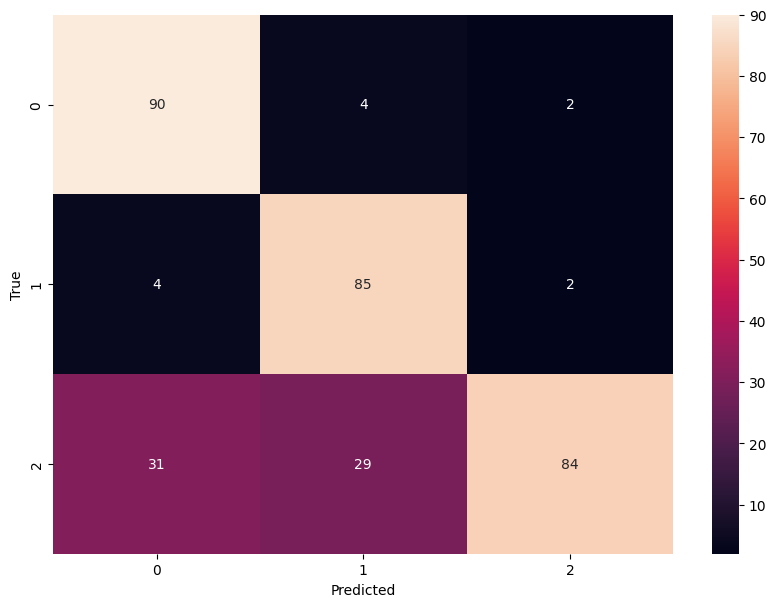

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# I went back to a simpler model using data augmentation, I played with the hyperparameters for hours trying to get the best combination: results in the clean notebook.